# Boxplot of top five up- and downregulated genes

In [18]:
suppressMessages({library(ggpubr)
                  library(tidyverse)
                  library(data.table)})

In [19]:
save_ggplots <- function(p, fn, w=7, h=7){
    for(ext in c('.svg', '.png', '.pdf')){
        ggsave(p, filename=paste0(fn, ext), width=w, height=h)
    }
}


add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
        as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
        dplyr::ungroup() %>%
        mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}


## Select most significant DEGs, up- and downregulated

In [20]:
genes = fread('../../metrics_summary/_m/male_specific_DE_genes.txt') %>%
    filter(Type == 'gene') %>% add_symnum()
up_genes = genes %>% filter(t > 0) %>% mutate('Direction'='Upregulated') %>% head(5)
down_genes = genes %>% filter(t < 0) %>% mutate('Direction'='Downregulated') %>% head(5)
sig_genes = bind_rows(up_genes, down_genes) %>% mutate_at(vars(Direction), as.factor)

for(xx in seq_along(sig_genes$Symbol)){
    sig_genes$New_ID[xx] <- ifelse(sig_genes$Symbol[xx] == '', 
                                   as.character(sig_genes$ensemblID[xx]), 
                                   as.character(sig_genes$Symbol[xx]))
}
sig_genes

Feature,gencodeID,Symbol,ensemblID,Chrom,logFC,t,adj.P.Val,Female_Pval,Female_FDR,Type,FDR,p.signif,Direction,New_ID
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>,<chr>
ENSG00000159871.14,ENSG00000159871.14,LYPD5,ENSG00000159871,chr19,0.21382215,5.885126,2.804273e-05,0.26492412,0.3061775,gene,2.8e-05,****,Upregulated,LYPD5
ENSG00000119411.10,ENSG00000119411.10,BSPRY,ENSG00000119411,chr9,0.28011040,5.861029,2.804273e-05,0.08173613,0.1396571,gene,2.8e-05,****,Upregulated,BSPRY
ENSG00000059691.11,ENSG00000059691.11,GATB,ENSG00000059691,chr4,0.11700988,5.115129,4.101529e-04,0.05253133,0.1089624,gene,0.00041,***,Upregulated,GATB
ENSG00000181045.14,ENSG00000181045.14,SLC26A11,ENSG00000181045,chr17,0.19181806,5.003328,5.409177e-04,0.09831680,0.1521188,gene,0.00054,***,Upregulated,SLC26A11
ENSG00000088280.18,ENSG00000088280.18,ASAP3,ENSG00000088280,chr1,0.17852547,4.753771,1.216475e-03,0.10321901,0.1571443,gene,0.00122,**,Upregulated,ASAP3
ENSG00000231752.5,ENSG00000231752.5,EMBP1,ENSG00000231752,chr1,-0.18942632,-5.536119,8.324115e-05,0.05362389,0.1102656,gene,8.3e-05,****,Downregulated,EMBP1
ENSG00000134086.7,ENSG00000134086.7,VHL,ENSG00000134086,chr3,-0.09550733,-4.564742,1.916778e-03,0.23680030,0.2833253,gene,0.00192,**,Downregulated,VHL
ENSG00000163347.5,ENSG00000163347.5,CLDN1,ENSG00000163347,chr3,-0.26576497,-4.511176,2.151185e-03,0.05013766,0.1063187,gene,0.00215,**,Downregulated,CLDN1
ENSG00000187416.11,ENSG00000187416.11,LHFPL3,ENSG00000187416,chr7,-0.16619628,-4.458308,2.583064e-03,0.05239601,0.1089624,gene,0.00258,**,Downregulated,LHFPL3


## Load phenotypes

In [21]:
pheno_file = paste0('/ceph/users/jbenja13/projects/sex_sz_ria/',
                    'input/commonMind/phenotypes/combine_files/',
                    '_m/CMC_phenotypes_all.csv')
pheno = fread(pheno_file) %>% 
    filter(Sex %in% c("XX", "XY"), 
           Dx %in% c("Control", "SCZ")) %>%
    mutate_if(is.character, as.factor) %>%
    select(c(Individual_ID, "RNAseq:Sample_RNA_ID", Dx, Sex))
colnames(pheno)[2] <- "SampleID"
levels(pheno$Sex) <- c("Female", "Male")
levels(pheno$Dx) <- c("CTL", "SZ")
pheno %>% head(2)

,Individual_ID,SampleID,Dx,Sex
,<fct>,<fct>,<fct>,<fct>
1,CMC_HBCC_003,CMC_HBCC_RNA_PFC_3158,CTL,Male
2,CMC_HBCC_005,CMC_HBCC_RNA_PFC_3152,CTL,Male


## Load residualized expression

In [22]:
res_file = paste0('/ceph/users/jbenja13/projects/sex_sz_ria/analysis/', 
                 'interaction_sex_sz/cmc_dlpfc/_m/genes/residualized_expression.tsv')
resdf0 = fread(res_file) %>% 
    filter(V1 %in% sig_genes$gencodeID) %>% 
    column_to_rownames(var="V1") %>% t %>% 
    as.data.frame %>% rownames_to_column() %>% 
    rename(SampleID=rowname) %>% 
    mutate_at("SampleID", as.factor)
resdf0[1:2, 1:5]

Warning message in fread(res_file):
"Detected 858 column names but the data has 859 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


,SampleID,ENSG00000059691.11,ENSG00000088280.18,ENSG00000119411.10,ENSG00000134086.7
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,MSSM_RNA_PFC_1,-0.5555575,0.3261466,-1.061502,0.4706272
2,MSSM_RNA_PFC_2,0.9681612,-0.1804660,1.030196,-1.3528444


### Merge and melt dataframe

In [23]:
df <- inner_join(pheno, resdf0, by="SampleID") %>%
    select(c('SampleID', 'Sex', 'Dx', starts_with('ENSG'))) %>% 
    pivot_longer(-c(SampleID, Sex, Dx), 
                 names_to='gencodeID', values_to="Res") %>% 
    inner_join(sig_genes, by='gencodeID') %>% 
    mutate_at(vars("New_ID", "Symbol", "gencodeID"), as.factor)
df$New_ID = with(df, reorder(New_ID, adj.P.Val, median))
df$Dx <- fct_drop(df$Dx)
dim(df)
df[1:2, 1:10]

[1] 8580   19

SampleID,Sex,Dx,gencodeID,Res,Feature,Symbol,ensemblID,Chrom,logFC
<fct>,<fct>,<fct>,<fct>,<dbl>,<chr>,<fct>,<chr>,<chr>,<dbl>
CMC_HBCC_RNA_PFC_3158,Male,CTL,ENSG00000059691.11,-0.4402167,ENSG00000059691.11,GATB,ENSG00000059691,chr4,0.1170099
CMC_HBCC_RNA_PFC_3158,Male,CTL,ENSG00000088280.18,0.4304603,ENSG00000088280.18,ASAP3,ENSG00000088280,chr1,0.1785255


### Initial ggplot with ggpubr

Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


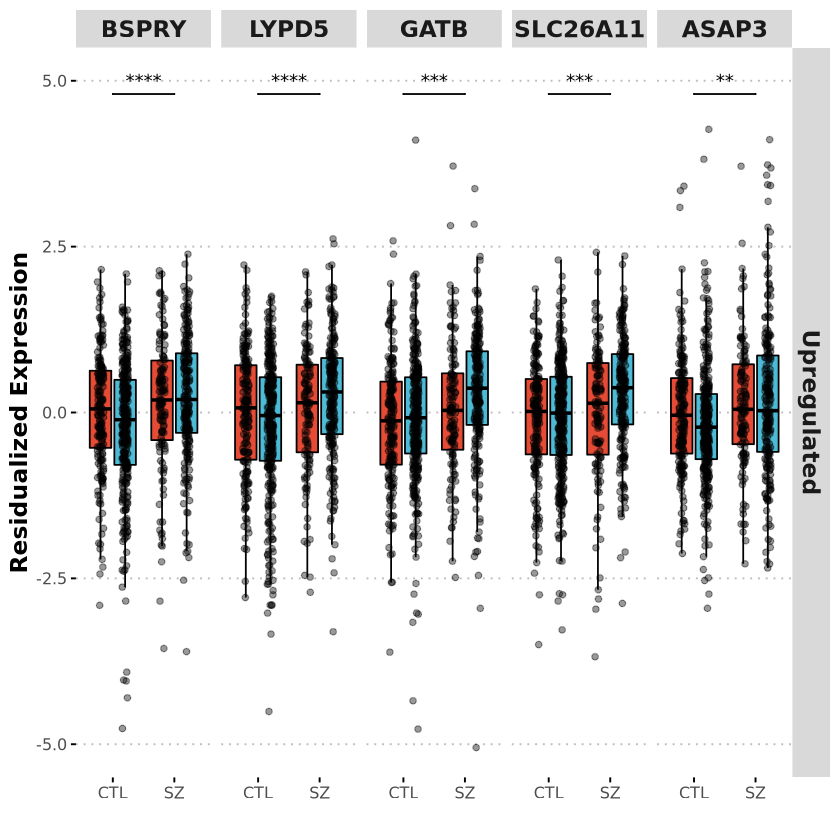

In [24]:
tmp = sig_genes %>% 
    mutate(group1='Female', group2='Male', y_pos=4.8) %>% 
    filter(Direction == 'Upregulated') %>%
    mutate_if(is.character, as.factor)

bxp_up <- df %>% filter(Direction=="Upregulated") %>%
        ggboxplot(x="Sex", y="Res", facet.by=c("Direction", "New_ID"), 
                  add='jitter', color="Dx", xlab='', palette="npg", 
                  panel.labs.font=list(face='bold'),  legend="",
                  ylab='Residualized Expression', ylim=c(-5, 5),
                  add.params=list(alpha=0.4), outlier.shape=NA, 
                  ggtheme=theme_pubclean(base_size=20)) +
         geom_signif(data=tmp, tip_length = 0,
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", face="bold") + font("legend.title", face="bold")
         
bxp_up

Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


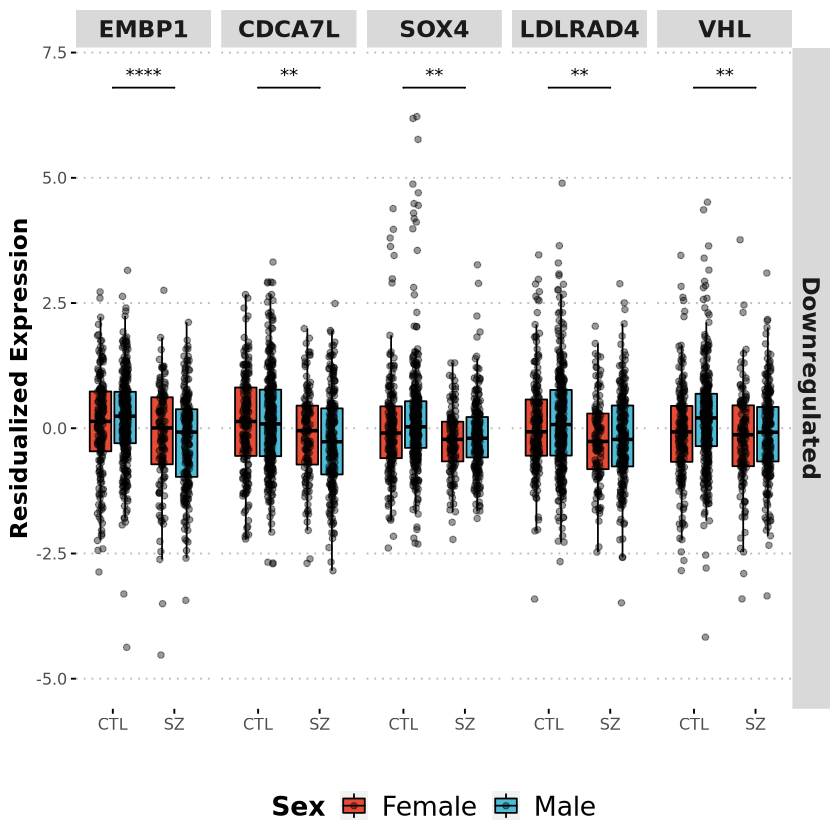

In [17]:
tmp = sig_genes %>% 
    mutate(group1='Female', group2='Male', y_pos=6.8) %>% 
    filter(Direction == 'Downregulated') %>%
    mutate_if(is.character, as.factor)

bxp_down <- df %>% filter(Direction=="Downregulated") %>%
        ggboxplot(x="Sex", y="Res", facet.by=c("Direction", "New_ID"), 
                  add='jitter', color="Dx", xlab='', palette="npg", 
                  panel.labs.font=list(face='bold'), legend="bottom", 
                  ylab='Residualized Expression', ylim=c(-5, 7),
                  add.params=list(alpha=0.4), outlier.shape=NA, 
                  ggtheme=theme_pubclean(base_size=20)) +
         geom_signif(data=tmp, tip_length = 0,
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", face="bold") + font("legend.title", face="bold")
         
bxp_down

### Annotate figure

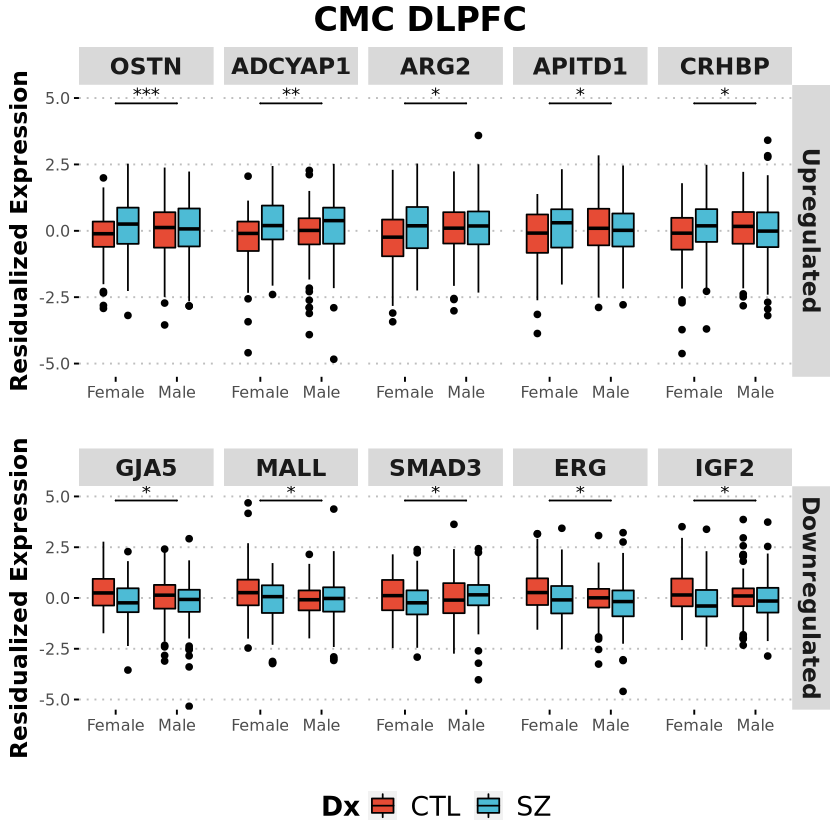

In [58]:
figure <- ggarrange(bxp_up, bxp_down, ncol = 1, nrow = 2, 
                    common.legend = TRUE, legend="bottom")
figure <- annotate_figure(figure, top=text_grob("CMC DLPFC", size=25, face='bold'))
figure

In [61]:
save_ggplots(figure, 'maleSpecific_SZ', 12, 10)

## Session Info

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()